In [11]:
import os
import sys
import math
import torch
import geopandas as gpd
import matplotlib as mtp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightning as lt

In [12]:
datasets_dir = os.path.join("/homeLocal/jpulzdeoliveira/datasets")
pastis_dir = os.path.join(datasets_dir, "PASTIS")

In [13]:
backend_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {backend_device} as backend device")

Using cuda as backend device


In [14]:
import ast
import json
from torch.utils.data import Dataset, random_split

def calculate_splits(length, percentages):
    assert np.sum(percentages) <= 1.0
    splits = []
    for p in percentages[:-1]:
        split_len = int(np.floor(p * length))
        splits.append(split_len)
        length -= split_len

    splits.append(length)
    return splits

def pre_load_data(parcels_file, norms_file=None, split=1.0):
    print("Reading parcels metadata...")
    meta_patch = pd.read_csv(parcels_file, converters={"bbox": ast.literal_eval})

    print("Calculating normalization...")
    # TODO: if norms_file == None then calculate norms of parcels
    with open(norms_file, 'r') as file:
        normvals = json.loads(file.read())
        folds = range(1, 6)
        means = [normvals[f"Fold_{f}"]["mean"] for f in folds]
        stds = [normvals[f"Fold_{f}"]["std"] for f in folds]
        mean = np.stack(means).mean(axis=0)
        mean = torch.from_numpy(mean).to(torch.float32)
        std = np.stack(stds).mean(axis=0)
        std = torch.from_numpy(std).to(torch.float32)

    (split,) = calculate_splits(len(meta_patch), [split])
    df1 = meta_patch.iloc[:split]
    df2 = meta_patch.iloc[split:]
    
    print("Done.")

    return (df1, df2,), (mean, std,)

In [15]:
from torchvision.transforms.functional import gaussian_blur, hflip, vflip, rotate, resize

def my_adjust_brigtness(img, factor):
    img = img * factor
    return img

def my_adjust_contrast(img, factor):
    mean = torch.mean(img, dim=(1, 2), keepdim=True)
    img = mean + factor * (img - mean)
    return img

def my_adjust_saturation(img, factor):
    gray = torch.mean(img, dim=0, keepdim=True)
    img = gray + factor * (img - gray)
    return img

class RandomPastisColorJitter:
    def __init__(
            self,
            probability,
            strength,
            brightness_factor,
            contrast_factor,
            saturation_factor
            ):
        self.probability = probability
        self.strength = strength
        self.brightness_factor = brightness_factor
        self.contrast_factor = contrast_factor
        self.saturation_factor = saturation_factor

    def __call__(self, data):
        if np.random.uniform() < self.probability:
            gfactor = np.random.uniform(low=1.0-self.strength, high=1.0+self.strength)
            data[[2, 1, 0]] = my_adjust_brigtness(data[[2, 1, 0]], self.brightness_factor * gfactor)
            data[[2, 1, 0]] = my_adjust_contrast(data[[2, 1, 0]], self.contrast_factor * gfactor)
            data[[2, 1, 0]] = my_adjust_saturation(data[[2, 1, 0]], self.saturation_factor * gfactor)
        return data

class RandomPastisGaussianBlur:
    def __init__(
            self,
            probability,
            sigmas,
            kernel=(1,3,)
            ):
        self.probability = probability
        self.sigmas = sigmas
        self.kernel = kernel

    def __call__(self, data):
        if np.random.uniform() < self.probability:
            data[[2, 1, 0]] = gaussian_blur(data[[2, 1, 0]], self.kernel, self.sigmas)
        return data

class RandomPastisVHFlip:
    def __init__(
            self,
            v_probability,
            h_probability
            ):
        self.v_probability = v_probability
        self.h_probability = h_probability

    def __call__(self, data):
        if np.random.uniform() < self.v_probability:
            data = vflip(data)
        if np.random.uniform() < self.h_probability:
            data = hflip(data)
        return data

class RandomPastisRotate:
    def __init__(
            self,
            probability,
            angle
            ):
        self.probability = probability
        if isinstance(angle, tuple):
            self.angle = angle
        else:
            self.angle = (-angle, angle)

    def __call__(self, data):
        if np.random.uniform() < self.probability:
            data = rotate(data, np.random.uniform(*self.angle))
        return data

class PastisNormalize:
    def __init__(
            self,
            std,
            mean
            ):
        self.std = std
        self.mean = mean

    def __call__(self, data):
        return self.normalize(data)

    def normalize(self, data):
        return (data - self.mean[:, None, None]) / self.std[:, None, None]

In [16]:
from torchvision.transforms import Compose
from torch.nn import functional

class FastSiamTransform:
    def __init__(
            self,
            n_views,
            norm_std,
            norm_mean,
            cj_prob,
            cj_strength,
            cj_bright,
            cj_contrast,
            cj_sat,
            gblur_prob,
            gblur_sigmas,
            gblur_kernel,
            v_flip_prob,
            h_flip_prob,
            rot_prob,
            rot_angles
            ):
        self.n_views = n_views
        self.pipeline = Compose([
            RandomPastisColorJitter(cj_prob, cj_strength, cj_bright, cj_contrast, cj_sat),
            RandomPastisGaussianBlur(gblur_prob, gblur_sigmas, gblur_kernel),
            RandomPastisVHFlip(v_flip_prob, h_flip_prob),
            RandomPastisRotate(rot_prob, rot_angles),
        ])
        self.normalization = PastisNormalize(norm_std, norm_mean)

    def __call__(self, data):
        views = [
            self.normalization(data.clone()),
            *list(self.normalization(self.pipeline(data.clone())) for _ in range(self.n_views))
        ]
        return views

class PASTISDatasetParcels(Dataset):
    def __init__(
        self,
        parcels_df,
        root,
        data_root,
        annotations_root,
        transforms,
        num_timestamps=3,
        sampled_count=3,
        mode='last' # or 'first'
        ):
        self.root = root
        self.data_root = data_root
        self.annotations_root = annotations_root
        self.num_timestamps = num_timestamps
        self.sampled_count = sampled_count
        self.transforms = transforms
        self.mode = mode

        print("Reading patch metadata...")
        self.meta_parcels = parcels_df
        self.len = num_timestamps * self.meta_parcels.shape[0]

        print("Done.")

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        parcel_index = index // self.num_timestamps
        parcel = self.meta_parcels.iloc[parcel_index]
        id = parcel.id
        bbox = parcel.bbox
        label = parcel.label
        
        data = np.load(os.path.join(self.data_root, f"S2_{id}.npy")).astype(np.float32)
        target = np.load(os.path.join(self.annotations_root, f"TARGET_{id}.npy"))
        target = target[0].astype(int)

        if self.mode == 'first':
            offset = index % self.num_timestamps
            selected_indexes = np.arange(self.sampled_count) + offset * self.sampled_count
        elif self.mode == 'last':
            offset = index % self.num_timestamps
            selected_indexes = np.arange(-self.sampled_count + 1, 1) - offset * self.sampled_count
            
        data = data[selected_indexes]

        data = np.median(data, axis=0)
        data = torch.from_numpy(data)
        target = torch.from_numpy(target)

        size = data.shape[1:]
        parcel = resize(data[:, bbox[0]:bbox[2], bbox[1]:bbox[3]], size)
        mask = target[bbox[0]:bbox[2], bbox[1]:bbox[3]] == label
        mask = functional.interpolate(
            mask.view(1, 1, *mask.shape).to(float),
            size=size,
            mode='nearest'
            ).view(*size).to(int)
        
        views = self.transforms(parcel)

        return (views, label, mask,)

In [17]:
from torchvision import transforms

print("\nTrain dataset.")

parcels_file = os.path.join("./pastis_parcels_cloud_analisys.csv")
norms_file = os.path.join(pastis_dir, "NORM_S2_patch.json")
(df, _, ), norm = pre_load_data(parcels_file, norms_file)

min_tmps_count = df.tmps_count.min()
print(f"Min timestamps per patch: {min_tmps_count}")

n_views = 4
pastis_transforms = FastSiamTransform(
    n_views,
    *norm, # Norm
    0.85, 0.1, 1.15, 1.25, 1.25, # Collor Jitter
    0.25, (0.1, 2.0,), (1, 3,), # Gauss Blur
    0.75, 0.75, # VH Flip
    0.6, 10.0 # Rot
    )
sample_count = 5
num_timestamps = int(min_tmps_count // sample_count)
dataset = PASTISDatasetParcels(
    df,
    pastis_dir,
    os.path.join("./pastis_cloud_refined"),
    os.path.join(pastis_dir, "ANNOTATIONS"),
    pastis_transforms,
    num_timestamps=num_timestamps,
    sampled_count=sample_count
    )
num_classes = 20
dataset_len = len(dataset)
print(f"Dataset len: {dataset_len}")
(x, y, t) = dataset[np.random.randint(dataset_len)]


Train dataset.
Reading parcels metadata...
Calculating normalization...
Done.
Min timestamps per patch: 26
Reading patch metadata...
Done.
Dataset len: 6775


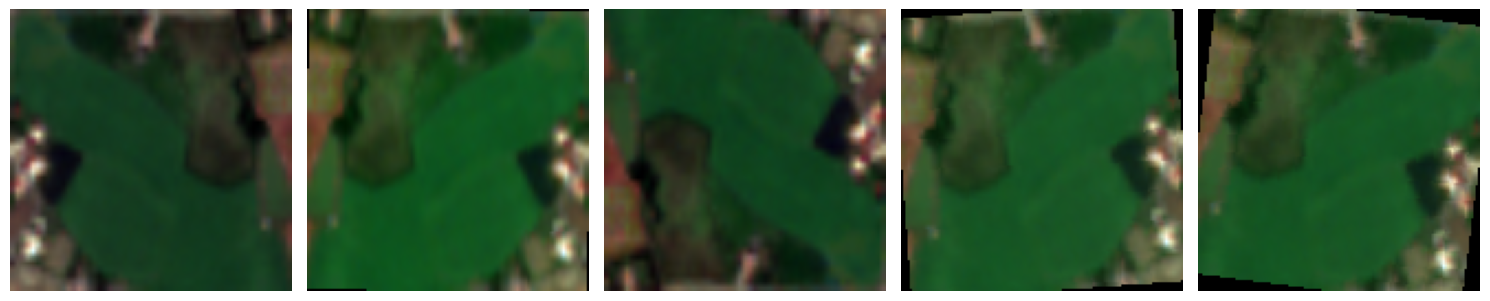

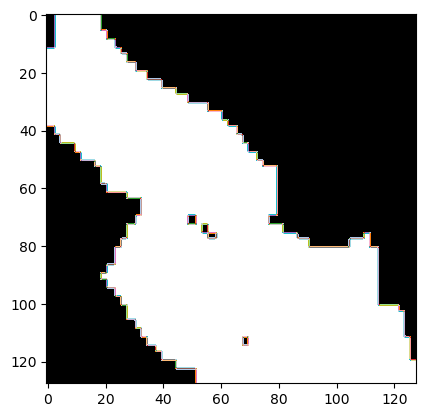

5


In [18]:
from matplotlib.colors import ListedColormap

cm = mtp.colormaps["tab20"]
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1, 20)] + ['w']
cmap = ListedColormap(colors=cus_colors, name="agri", N=21)

def get_input_rgb(x):
    im = x[[2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None]) / (mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = get_input_rgb(x[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.imshow(t, cmap=cmap)
plt.show()
print(y)

In [19]:
import multiprocessing
from torch.utils.data import DataLoader, random_split

# TODO
class PastisDataModule(lt.LightningDataModule):
    def __init__(self, dataset, splits, dataloader_args):
        self.dataset = dataset
        self.splits = splits
        self.dataloader_args = dataloader_args

    def setup(self, _):
        percentages = []
        splits = []
        if 'train' in self.splits:
            splits.append('train')
            percentages.append(self.splits['train'])
            self.train_dataloader = self._train_dataloader
        if 'test' in self.splits:
            splits.append('test')
            percentages.append(self.splits['test'])
            self.test_dataloader = self._test_dataloader
        if 'val' in self.splits:
            splits.append('val')
            percentages.append(self.splits['val'])
            self.val_dataloader = self._val_dataloader
            
        subsets_splits = random_split(
            self.dataset,
            calculate_splits(len(self.dataset), percentages)
            )
        self.subsets = {}
        for i, k in enumerate(splits):
            self.subsets[k] = subsets_splits[i]

    def _train_dataloader(self):
        return DataLoader(
            self.subsets['train'],
            **self.dataloader_args['train']
            )

    def _test_dataloader(self):
        return DataLoader(
            self.subsets['test'],
            **self.dataloader_args['test']
            )

    def _val_dataloader(self):
        return DataLoader(
            self.subsets['val'],
            **self.dataloader_args['val']
            )

num_workers = multiprocessing.cpu_count() * 2 // 5
pastis_datamodule = PastisDataModule(
    dataset,
    { 'train': 0.9, 'test': 0.1 },
    {
        'train': { 'batch_size': 256, 'shuffle': True, 'num_workers': num_workers, 'pin_memory': True, 'drop_last': True },
        'test': { 'batch_size': 256, 'num_workers': num_workers }
    },
    )

splits = calculate_splits(len(dataset), [0.9, 0.1])
train_set, test_set = random_split(dataset, splits)
batch_size = 64
pastis_dataloader = {
    'train': DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        persistent_workers=True
        ),
    'test': DataLoader(
        test_set,
        batch_size=batch_size,
        num_workers=num_workers
        ),
}

In [20]:
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from lightly.models.modules import heads

class PreTrainFastSiam(nn.Module):
    def __init__(self):
        super().__init__()
        resnet50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        resnet50_model.conv1 = nn.Conv2d(10, 64, kernel_size=(7, 7,), stride=(2, 2,), padding=(3, 3,), bias=False)
        self.backbone = nn.Sequential(*list(resnet50_model.children())[:-1])
        self.proj_head = heads.SimSiamProjectionHead(input_dim=2048, hidden_dim=2048, output_dim=2048)
        self.pred_head = heads.SimSiamPredictionHead(input_dim=2048, hidden_dim=1024, output_dim=2048)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.proj_head(f)
        p = self.pred_head(z)
        z = z.detach()
        return f, z, p

# TODO
class LightningPreTrain(lt.LightningModule):
    def __init__(self, backbone, loss_fn, optim, scheduler):
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.optim = optim
        self.scheduler = scheduler

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_id):
        x, y = batch
        features = [self(view.to(device)) for view in x]
        fs, zs, ps = [], [], []
        for f, z, p in features:
            fs.append(f)
            zs.append(z)
            ps.append(p)
        fs = torch.stack(fs)
        zs = torch.stack(zs)
        ps = torch.stack(ps)

        n_views = len(x)
        loss = 0.0
        for i in range(n_views):
            mask = torch.arange(n_views, device=x.device) != i
            loss += self.loss_fn(ps[i], torch.mean(zs[mask], dim=0)) / n_views

        self.log("train_loss", loss, prog_bar=True)

        return loss

pretrain_model = PreTrainFastSiam()
print(pretrain_model)

PreTrainFastSiam(
  (backbone): Sequential(
    (0): Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [21]:
import signal
from abc import ABC, abstractmethod
from datetime import datetime
from lightly.utils.debug import std_of_l2_normalized
from torch.nn import CrossEntropyLoss, functional
from torch.optim import Adam
from tqdm import tqdm

class AveragePerBatchMetric():
    def __init__(self, criteria):
        self.criteria = criteria
        self.values = []
    
    @abstractmethod
    def append(self, y_hat, y):
        pass

    @abstractmethod
    def get(self):
        mean = np.mean(self.values)
        self.values = []
        return mean

stop = False
def handler(sig, frame):
    global stop
    if not stop:
        print("stopping next training iteration")
    stop = True

def stop_callback():
    signal.signal(signal.SIGINT, handler)

class LinProbeSimSiam(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.backbone = None
        self.imm_fc = nn.Linear(in_features=2048, out_features=512)
        self.out_fc = nn.Linear(in_features=512, out_features=out_features)

    def copy_backbone(self, resnet50_n1):
        self.backbone = nn.Sequential(*list(resnet50_n1.children()))
        for param in self.backbone.parameters(): # Freeze
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
            x = x.view(x.size(0), -1)
        x = self.imm_fc(x)
        x = functional.relu(x)
        x = self.out_fc(x)
        return x

def train_one_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device,
    use_amp,
    max_norm
    ):
    model.train()
    start_time = datetime.now()
    
    scaler = torch.cuda.amp.GradScaler()
    collapse = ([], [], [],)
    losses = []
    for views, _0, _1 in tqdm(dataloader, desc="train batches", leave=False, position=0):
        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            features = [model(view.to(device)) for view in views]

        fs, zs, ps = [], [], []
        for f, z, p in features:
            fs.append(f)
            zs.append(z)
            ps.append(p)
        fs = torch.stack(fs)
        zs = torch.stack(zs)
        ps = torch.stack(ps)

        n_views = len(x)
        loss = 0.0
        for i in range(n_views):
            mask = torch.arange(n_views, device=device) != i
            loss += loss_fn(ps[i], torch.mean(zs[mask], dim=0)) / n_views
        
        scaler.scale(loss).backward()

        losses.append(loss.item())

        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
            
        optimizer.zero_grad(set_to_none=True)

        collapse[0].append(std_of_l2_normalized(fs[0]))
        collapse[1].append(std_of_l2_normalized(zs[0]))
        collapse[2].append(std_of_l2_normalized(ps[0]))

    collapse = [torch.stack(coll, dim=0).cpu().numpy() for coll in collapse]
    collapse_level = np.mean(collapse, axis=0)
    
    end_time = datetime.now()
    timespan = end_time - start_time

    return (timespan, losses, collapse_level,)

def linear_probing(
    model_lp,
    dataloader,
    loss_fn,
    optimizer,
    device,
    use_amp,
    max_norm
    ):
    model_lp.train()
    start_time = datetime.now()

    scaler = torch.cuda.amp.GradScaler()
    losses = []
    for views, y, _ in tqdm(dataloader, desc="linear probing batches", leave=False, position=0):
        x1 = views[1].to(device)
        y = y.to(device)

        with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
            y_hat = model_lp(x1)
            loss = loss_fn(y_hat, y)

        loss_val = loss.item()
        losses.append(loss_val)
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model_lp.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        
        optimizer.zero_grad(set_to_none=True)

    end_time = datetime.now()
    timespan = end_time - start_time

    return (timespan, np.mean(losses),)
        
@torch.no_grad()
def test_one_epoch(
    model_lp,
    dataloader,
    metrics,
    device
    ):
    model_lp.eval()
    start_time = datetime.now()

    for views, y, _ in tqdm(dataloader, desc="test batches", leave=False, position=0):
        x0= views[0].to(device)
        y = y.to(device)

        y_hat = model_lp(x0)

        for key in metrics:
            metrics[key].append(y_hat, y)

    end_time = datetime.now()
    timespan = end_time - start_time

    return (timespan,)
    
def train(
    model,
    model_lp,
    dataloader,
    loss_fn,
    optimizer,
    scheduler,
    metrics,
    device,
    epochs,
    test_interval=1,
    checkpoints=5,
    checkpoints_dir=None,
    report_interval=1,
    use_amp=True,
    max_norm=0.1
    ):
    metrics_history = {
        'train': {},
        'test': {
            key: ([]) for key in metrics['test']
        }
    }
    metrics_history['train']['loss'] = []

    def save_checkpoint(epoch, model, optimizer, checkpoints_dir=None):
        checkpoint_path = f"checkpoint_pastis.pth"
        if checkpoints_dir is not None:
            checkpoint_path = os.path.join(checkpoints_dir, checkpoint_path)
        print(f"saving checkpoint {checkpoint_path}")
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            },
            checkpoint_path
            )

    model.to(device)
    model_lp.to(device)
    loss_fn_lp = CrossEntropyLoss() # TODO: pesos
    optim_lp = Adam(model_lp.parameters(), lr=0.001)
    for epoch in range(1, epochs + 1):
        if stop:
            break

        # Train
        timespan, losses, collapse = train_one_epoch(
            model,
            dataloader['train'],
            loss_fn,
            optimizer,
            device,
            use_amp,
            max_norm
        )
        print(
            f"==============================================\n"
            f"EPOCH {epoch:4d}\n"
            "train results:"
            )
        loss = np.mean(losses)
        metrics_history['train']['loss'].append(loss)
        print(
            f"\ttimespan: {timespan}\n"
            f"\tloss: {loss:.4f}\n"
            f"\tcollapse lvl:\n"
            f"\t\tf0: {collapse[0]:.4f}\n"
            f"\t\tz0: {collapse[1]:.4f}\n"
            f"\t\tp0: {collapse[2]:.4f}"
            )

        # Test
        if epoch % test_interval == 0:
            model_lp.copy_backbone(model.backbone)
            (timespan, loss,) = linear_probing(
                model_lp,
                dataloader['train'],
                loss_fn_lp,
                optim_lp,
                device,
                use_amp,
                max_norm
                )
            print(
                "linear probing results:\n"
                f"\ttimespan: {timespan}\n",
                f"\tloss: {loss}"
                )
            
            (timespan,) = test_one_epoch(
                model_lp,
                dataloader['test'],
                metrics['test'],
                device
                )
            print(
                "test results:\n"
                f"\ttimespan: {timespan}"
                )
            for key in metrics['test']:
                score = metrics['test'][key].get()
                metrics_history['test'][key].append(score)
                print(f"\t{key}: {score:.4f}")

        scheduler.step()

        if checkpoints is not None and epoch % checkpoints == 0:
            save_checkpoint(epoch, model, optimizer, checkpoints_dir)

    return metrics_history

In [12]:
import warnings
from lightly.loss import NegativeCosineSimilarity
from torch import optim
from torch.optim import lr_scheduler
from sklearn.metrics import balanced_accuracy_score

class AverageAccuracy(AveragePerBatchMetric):
    def __init__(self):
        super().__init__(balanced_accuracy_score)

    def append(self, y_hat, y):
        predicted = torch.argmax(y_hat, dim=1)
        acc = self.criteria(y.cpu().numpy(), predicted.cpu().numpy())
        self.values.append(acc)

stop_callback()

#torch.autograd.set_detect_anomaly(True)
torch.use_deterministic_algorithms(True, warn_only=True)
torch.backends.cudnn.benchmark = True

model_lp = LinProbeSimSiam(num_classes)
loss_fn = NegativeCosineSimilarity()
learning_rate = 0.06 * batch_size / 256
optimizer = optim.Adam(
    pretrain_model.parameters(),
    lr=learning_rate,
    weight_decay=5e-4
)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
metrics = {
    'test': { 'accuracy': AverageAccuracy() }
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = train(
        pretrain_model,
        model_lp,
        pastis_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        metrics,
        backend_device,
        100,
        checkpoints=10,
        report_interval=1,
        test_interval=10
        )

EPOCH    1
train results:
	timespan: 0:01:09.080308
	loss: -0.7083
	collapse lvl:
		f0: 0.0196
		z0: 0.0196
		p0: nan


linear probing results:
	timespan: 0:01:10.366487
 	loss: 2.0898114856920746


test results:
	timespan: 0:00:24.623144
	accuracy: 0.1047


EPOCH    2
train results:
	timespan: 0:02:49.009795
	loss: -0.8587
	collapse lvl:
		f0: 0.0159
		z0: 0.0160
		p0: 0.0160


linear probing results:
	timespan: 0:02:23.395017
 	loss: 2.034702541953639


test results:
	timespan: 0:00:25.728585
	accuracy: 0.0913


EPOCH    3
train results:
	timespan: 0:02:43.744829
	loss: -0.8666
	collapse lvl:
		f0: 0.0160
		z0: 0.0161
		p0: 0.0161


linear probing results:
	timespan: 0:02:02.402413
 	loss: 2.0327223526804072


test results:
	timespan: 0:00:19.456286
	accuracy: 0.0851


EPOCH    4
train results:
	timespan: 0:02:07.095452
	loss: -0.8846
	collapse lvl:
		f0: 0.0159
		z0: 0.0161
		p0: 0.0158


linear probing results:
	timespan: 0:02:07.002122
 	loss: 2.0173269974557977


test results:
	timespan: 0:00:22.974487
	accuracy: 0.0945


train batches:   0%|                                                                             | 0/95 [00:00<?, ?it/s]

stopping next training iteration
stopping next training iterationstopping next training iterationstopping next training iterationstopping next training iterationstopping next training iterationstopping next training iterationstopping next training iterationstopping next training iteration









EPOCH    5
train results:
	timespan: 0:02:37.852288
	loss: -0.8924
	collapse lvl:
		f0: 0.0162
		z0: 0.0160
		p0: 0.0158


linear probing results:
	timespan: 0:02:13.469756
 	loss: 2.019643161171361


test results:
	timespan: 0:00:19.035482
	accuracy: 0.1026


In [15]:
save_path = os.path.join("/homeLocal/jpulzdeoliveira/models/", "pastis_fastsiam.pth")
torch.save(pretrain_model.state_dict(), save_path)

In [22]:
save_path = os.path.join("/homeLocal/jpulzdeoliveira/models/", "pastis_fastsiam.pth")
pretrain_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

samples = []
labels = []
embeddings = []

pretrain_model.eval()
with torch.no_grad():
    for (view, y, _) in tqdm(pastis_dataloader['test']):
        x0 = view[0]
        y_hat = pretrain_model.cuda().backbone(x0.cuda()).flatten(start_dim=1)
        samples.extend(x0[:, [2, 1, 0]])
        labels.extend(y)
        embeddings.append(y_hat)

embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

projection = PCA(n_components=50)
embeddings_2d = projection.fit_transform(embeddings)

clusterizator = TSNE(n_components=2)
embedding_clusters = clusterizator.fit_transform(embeddings_2d)

M = np.max(embedding_clusters, axis=0)
m = np.min(embedding_clusters, axis=0)
embedding_clusters = (embedding_clusters - m) / (M - m)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.66it/s]


678 678


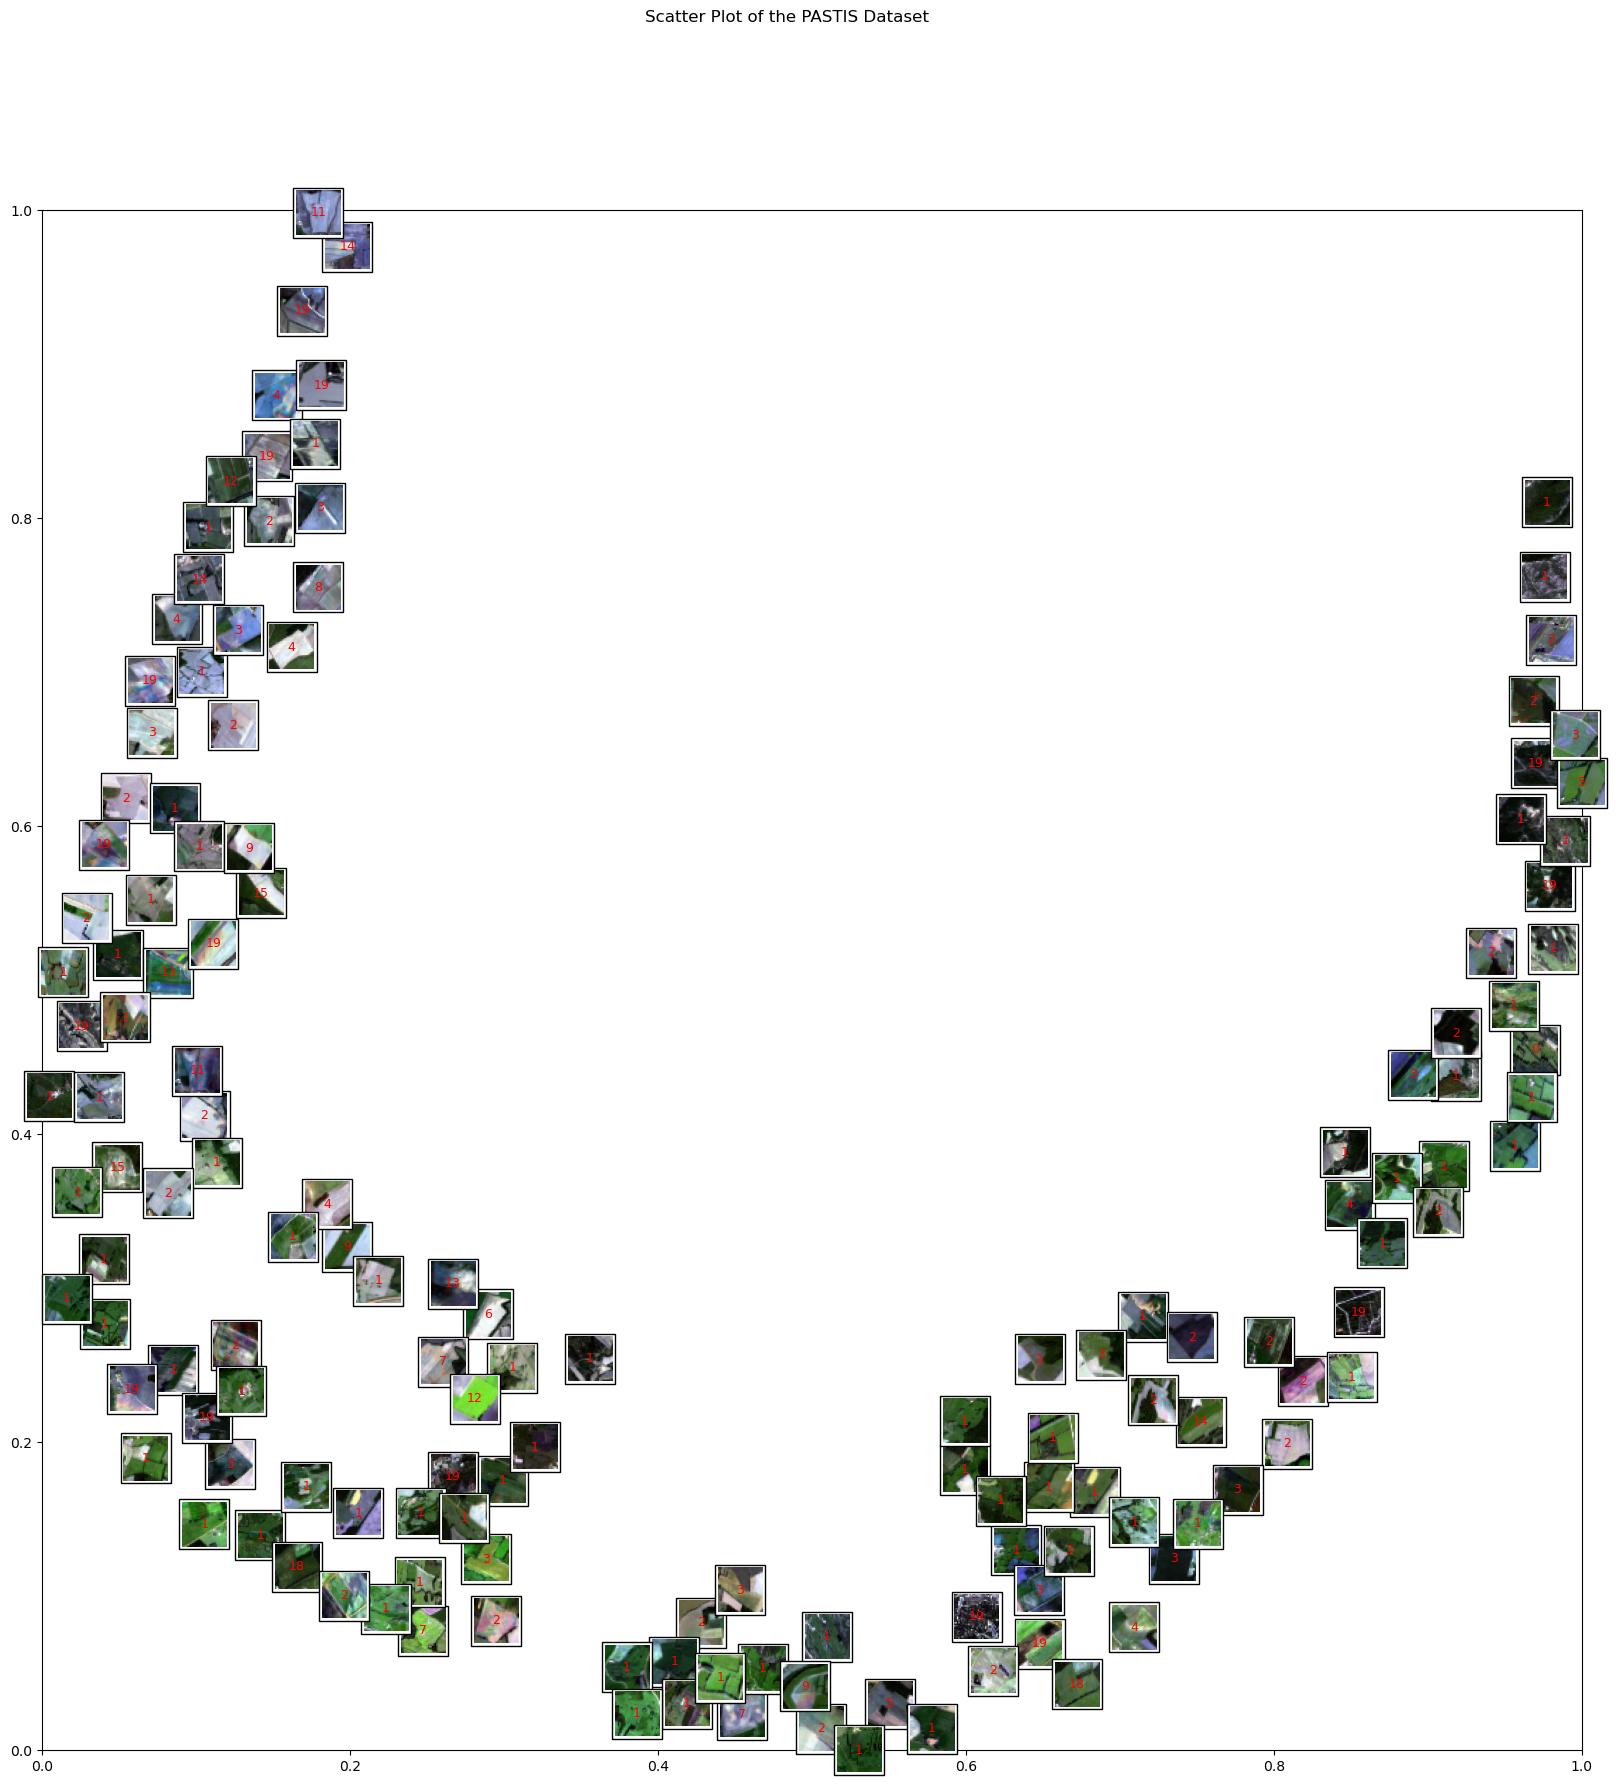

In [42]:
from matplotlib import offsetbox
from matplotlib import rcParams
from torch.nn import functional

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Scatter Plot of the PASTIS Dataset")
ax = fig.add_subplot(1, 1, 1)

shown_images_idx = []
shown_images = np.array([[1.0, 1.0]])
iterator = [i for i in range(embedding_clusters.shape[0])]
np.random.shuffle(iterator)
threshold = 7.5e-4
for i in iterator:
    dist = np.sum((embedding_clusters[i] - shown_images) ** 2, 1)
    if np.min(dist) < threshold:
        continue
    shown_images = np.r_[shown_images, [embedding_clusters[i]]]
    shown_images_idx.append(i)

for idx in shown_images_idx:
    thumbnail_size = int(rcParams["figure.figsize"][0] * 5.0)
    img = samples[idx]
    img = functional.interpolate(img.unsqueeze(0), size=(thumbnail_size,) * 2).squeeze(0)
    img = get_input_rgb(img)
    img_box = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(img, cmap=plt.cm.gray_r),
        embedding_clusters[idx],
        pad=0.2,
        )
    label = labels[idx]
    ax.add_artist(img_box)
    ax.text(embedding_clusters[idx][0], embedding_clusters[idx][1], f'{label}', 
            fontsize=9, ha='center', va='center', color='red')

ratio = 1.0 / ax.get_data_ratio()
ax.set_aspect(ratio, adjustable="box")
fig.savefig('thumbnails_plot.png')